### Overview of the solution:

- read first and last names from the dbpedia dataset and read non-names 
- all names and words are split into 3 categories: 
    - `train` for trainig the model
    - `validation` for parameter tuning
    - `test` for final evaluation
- building the training data:
    - positive labels: randomly sampling first and second name
    - negative labels: word + first name and last name + word
    - negative labels: randomly sampling words
    - only 1/8 of labels are positive
- model is SVM with L1 penalty on character-based ngrams, n=2,3,4

In [1]:
import re
import codecs

from time import time

from tqdm import tqdm
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score, confusion_matrix

import seaborn as sns
%matplotlib inline

/home/agrigorev/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
first_names = set()
last_names = set()

with codecs.open('persondata_en.nt', 'r', 'utf8') as names:
    for line in tqdm(names):
        if '<http://xmlns.com/foaf/0.1/surname>' in line and "@en" in line:
            match = re.search('"(.+?)"@en', line)
            if match:
                last_names.add(match.group(1).lower())
        elif '<http://xmlns.com/foaf/0.1/givenName>' in line and "@en" in line:
            match = re.search('"(.+?)"@en', line)
            if match:
                first_names.add(match.group(1).lower())

In [3]:
len(first_names), len(last_names)

(206054, 331377)

In [4]:
first_names = sorted(first_names)
last_names = sorted(last_names)

In [5]:
first_names[:10]

[u'%20johann%20michael',
 u"'''ali sayyid muhamed mustafa al-",
 u"'''friedrich f.",
 u"'''karl georg otto willibald",
 u"'''lester whyland",
 u"'''major general salihu zaway",
 u"'''philibert-emmanuel de froulay de",
 u"'aisake",
 u"'ana",
 u"'antigone"]

In [6]:
first_names = [n for n in first_names if n.isalpha() and len(n) >= 3]
last_names = [n for n in last_names if n.isalpha() and len(n) >= 3]

In [7]:
print first_names[:10]
print last_names[:10]

[u'aaaa', u'aaaron', u'aabid', u'aad', u'aadarsh', u'aadel', u'aadesh', u'aadhavan', u'aadil', u'aaditya']
[u'aab', u'aabech', u'aabel', u'aaberg', u'aaboe', u'aaboubou', u'aabrek', u'aabrekk', u'aabrink', u'aabroo']


In [8]:
len(first_names), len(last_names)

(73738, 282833)

In [9]:
with codecs.open('corncob_lowercase.txt', 'r', 'utf-8') as words:
    non_names = {w.strip() for w in words}

non_names = non_names - set(first_names)- set(last_names)
non_names = sorted(non_names)

In [10]:
print non_names[:10]

[u'aardvark', u'aardwolf', u'aback', u'abaft', u'abalone', u'abandon', u'abandoned', u'abandonment', u'abandons', u'abase']


In [11]:
len(non_names)

50665

In [12]:
def train_val_test(input, seed=1):
    np.random.seed(seed)
    n = len(input) / 5
    test = set(np.random.choice(input, size=n, replace=False))
    alltrain = set(input) - test

    n = len(alltrain) / 5
    val = set(np.random.choice(list(alltrain), size=n, replace=False))
    train = alltrain - val
    return list(train), list(val), list(test)

first_train, first_val, first_test = train_val_test(first_names)
last_train, last_val, last_test = train_val_test(last_names)
words_train, words_val, words_test = train_val_test(non_names)

In [13]:
print first_train[:10]
print first_val[:10]
print first_test[:10]

print

print last_train[:10]
print last_val[:10]
print last_test[:10]

[u'fawn', u'royengyot', u'hisami', u'darryll', u'viyaket', u'roppyaku', u'woods', u'fawz', u'gavan', u'whestley']
[u'taunggwin', u'ethelda', u'manshichi', u'kayacan', u'sonja', u'ioana', u'amilton', u'suzann', u'foluke', u'francesco']
[u'mohini', u'arihiro', u'tajudeen', u'pradeeth', u'evalyn', u'cobie', u'gailene', u'keno', u'giennadij', u'elving']

[u'shimmell', u'tsukino', u'clottes', u'akogyiram', u'verplank', u'nualart', u'clottey', u'paizs', u'gavai', u'shatzky']
[u'golyaev', u'kurtagic', u'sowell', u'blondeau', u'tilton', u'rudnay', u'woods', u'jardler', u'gandhirajan', u'woody']
[u'poovarawan', u'dachev', u'turisbekov', u'schwoch', u'mccomish', u'teibert', u'batticciotto', u'seifen', u'klatka', u'melosh']


## Preparing the data

In [14]:
def prepare_data(first, last, words, target_size, seed=1):
    np.random.seed(seed)

    positive_n = target_size / 8
    negagive_n = 5 * target_size / 8


    valid_names = pd.DataFrame({
            'first': np.random.choice(first, size=positive_n), 
            'second': np.random.choice(last, size=positive_n)})
    valid_names['target'] = 1

    part_name_1 = pd.DataFrame({
            'first': np.random.choice(words, size=positive_n),
            'second': np.random.choice(first, size=positive_n), 
            })
    part_name_1['target'] = 0

    part_name_2 = pd.DataFrame({
            'first': np.random.choice(last, size=positive_n),
            'second': np.random.choice(words, size=positive_n)
            })
    part_name_2['target'] = 0

    not_names = pd.DataFrame({
            'first': np.random.choice(words, size=negagive_n),
            'second': np.random.choice(words, size=negagive_n)
            })
    not_names['target'] = 0

    result = pd.concat([valid_names, part_name_1, part_name_2])
    result = pd.concat([result, not_names]).reset_index(drop=1)

    result['candidate'] = result['first'] + ' ' + result['second']
    del result['first'], result['second']
    result = result.reindex(np.random.permutation(result.index))
    return result

In [15]:
df_train = prepare_data(first_test, last_test, words_train, target_size=500000)
df_train.head()

,target,candidate
426181,0,nightmares extendible
418277,0,wellrounded sieving
56705,1,miwa jongsma
206685,0,undesired warps
216313,0,assassinating responsible


In [16]:
df_train.target.mean()

0.125

In [17]:
df_val = prepare_data(first_val, last_val, words_val, target_size=150000)
df_val.head()

,target,candidate
141970,0,contractually muggy
9616,1,tangia macgiollaphadraig
14536,1,dul duminda
74275,0,ungerminated deepens
18725,1,gon azimaei


In [18]:
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(2, 4), min_df=10)
X = tfidf.fit_transform(df_train.candidate)
y = df_train.target

In [19]:
X.shape

(500000, 58126)

In [20]:
X_val = tfidf.transform(df_val.candidate)
y_val = df_val.target

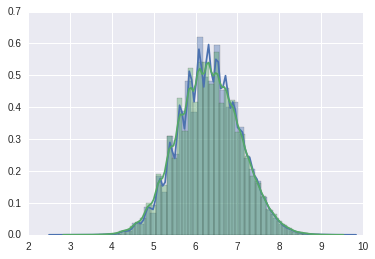

In [21]:
sns.distplot(X.sum(axis=1))
sns.distplot(X_val.sum(axis=1))

In [22]:
for C in [0.0001, 0.001, 0.01, 0.1, 0.5]:
    t0 = time()
    svm = LinearSVC(penalty='l1', dual=False, random_state=1, C=C)
    svm.fit(X, y)

    print 'fit for C=%f took %0.3fs' % (C, time() - t0)
    res = svm.decision_function(X_val)
    auc = roc_auc_score(y_val, res)
    print 'auc=%0.5f' % (auc)

fit for C=0.000100 took 2.891s
auc=0.50000
fit for C=0.001000 took 4.409s
auc=0.87314
fit for C=0.010000 took 19.434s
auc=0.95043
fit for C=0.100000 took 178.173s
auc=0.97817
fit for C=0.500000 took 203.926s
auc=0.98282


The best auc is $98\%$ obrained with $C=0.5$. Maybe larger $C$ would work better, but we'll use $0.5$

Let's retrain using this $C$ and all train+val dataset. 

In [23]:
df_train_full = pd.concat([df_train, df_val])
df_train_full.shape

(650000, 2)

In [24]:
df_test = prepare_data(first_test, last_test, words_test, target_size=150000)
df_test.head()

,target,candidate
92649,0,rinds businessmen
6618,1,lurlene kotrikadze
2952,1,vilhem zonzolo
57321,0,habitforming masquerades
17841,1,assumpta vecsey


In [25]:
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(2, 4), min_df=10)
X = tfidf.fit_transform(df_train_full.candidate)
y = df_train_full.target

In [26]:
X_test = tfidf.transform(df_test.candidate)
y_test = df_test.target

In [27]:
best_C = 0.5

t0 = time()
svm = LinearSVC(penalty='l1', dual=False, random_state=1, C=best_C)
svm.fit(X, y)

print 'fit for C=%f took %0.3fs' % (C, time() - t0)
res = svm.decision_function(X_test)
auc = roc_auc_score(y_test, res)
print 'auc=%0.5f' % (auc)

fit for C=0.500000 took 315.983s
auc=0.98966


In [28]:
predicted_labels = (res > 0).astype(int)
(tp, fn), (fp, tn) = confusion_matrix(y_test, predicted_labels) 

p = 1.0 * tp / (tp + fp)
r = 1.0 * tp / (tp + fn)
print 'precision = %.4f' % p
print 'recall    = %.4f' % r
print 'f1        = %.4f' % (2 * p * r / (p + r))

precision = 0.9855
recall    = 0.9753
f1        = 0.9804


Examples of correctly and incorrectly classified items

In [29]:
results = df_test.copy()
results.insert(1, 'predicted', predicted_labels)

print 'incorrectly classified'
results[predicted_labels != y_test].sample(n=20, random_state=1)

incorrectly classified


,target,predicted,candidate
38303,0,1,joessang sorghum
45864,0,1,gevay soubriquet
10439,1,0,mortimer knicely
86713,0,1,divorce afield
33903,0,1,stolen hardeo
49232,0,1,grasdorp imbue
55410,0,1,mholo stylus
16287,1,0,fitz hecking
5343,1,0,kunga provest
10217,1,0,deck magrane


In [31]:
print 'names correctly classified'
results[(y_test == 1) & (predicted_labels == y_test)].sample(n=10, random_state=1)

names correctly classified


,target,predicted,candidate
13421,1,1,motlatsi lautenberg
4396,1,1,ozalp liljevalch
16917,1,1,judianne vukovic
6137,1,1,janni balakian
1983,1,1,gerardo simkhovitch
2367,1,1,ahrn eisenhoffer
7326,1,1,rasheim bertling
13153,1,1,espy bertka
10323,1,1,dattatraya milliron
2084,1,1,shengwu maggard


In [32]:
print 'not names correctly classified'
results[(y_test == 0) & (predicted_labels == y_test)].sample(n=10, random_state=1)

not names correctly classified


,target,predicted,candidate
55173,0,0,sakho spitfire
32040,0,0,lilting sukhrob
138641,0,0,intifada aniline
74742,0,0,unloads volatility
67835,0,0,mutilated megalomaniacs
73109,0,0,neatest stockade
142024,0,0,fiord sprats
120805,0,0,rivulet costed
75540,0,0,voyaged sinfully
139648,0,0,placate reluctantly


The model is very simplistic and makes very stong assumptions, but otherwise it would be too time consuming.

The proper way for detecting names could be to use CRF (e.g. via https://github.com/tpeng/python-crfsuite). Training data could come from wikipedia or common crawl or some other text corpus, and labels for names could be obtained from dbpedia like here. There are also some corpuses with labeled named entities.